# Test on the simplest audio clip.

Create a synthetic audio clip or a musical scale plus some background noise.

## Imports

In [1]:
import os
import numpy as np
import torch
import IPython.display as ipd
import audio_classifier_visualizer as acv

try:
    import cupy
    os.environ['SSQ_GPU'] = '1'
    print("If this works, cupy is working",cupy.arange(10))
except ImportError as e:
    if torch.cuda.is_available():
        print("For faster performance you may want to `pip install cupy-cuda12x`")


If this works, cupy is working [0 1 2 3 4 5 6 7 8 9]


## Make a short audio test clip

In [2]:
sample_rate = 44100
duration = 10
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)  # Time array

# Frequencies for the scale from middle C (261.63 Hz) to the octave above (523.25 Hz)
frequencies = [261.626, 293.66, 329.63, 349.23, 392.00, 440.00, 493.88, 523.25]
waveform = np.concatenate([0.5 * np.sin(2 * np.pi * f * t[:int(sample_rate * 8 / len(frequencies))]) for f in frequencies])
waveform = np.concatenate([waveform, np.zeros(int(sample_rate * 2))])  # Add 2 seconds of silence at the end
lower_c_frequency = 130.81  # Frequency for lower C (C2)
noise_waveform = np.random.normal(0, 0.5, waveform.shape)  # Generate noise with mean 0 and standard deviation 0.1
waveform += noise_waveform  # Add noise to the waveform

ipd.Audio(waveform,rate=sample_rate)


In [3]:

features_per_second = 2
features = np.concatenate([np.array([note+1 for x in range(features_per_second)]) for note in range(len(frequencies))])
features = np.concatenate([features, np.zeros(int(features_per_second * 2))])
features.shape

logits = np.zeros((features_per_second * 10, 9))  # Initialize logits with zeros
for i in range(8):
    logits[i * features_per_second:(i + 1) * features_per_second, i] = 1.0  # Set the highest value for each note in its corresponding second
logits[features_per_second * 8:features_per_second * 10, 8] = 1.0
noise = np.random.normal(0, 0.1, logits.shape)  # Generate noise with mean 0 and standard deviation 0.1
logits += noise  # Add noise to the logits
logits *= 10

print(features.shape,logits.shape)

import torch
logits_tensor = torch.tensor(logits)
probabilities = torch.softmax(logits_tensor, dim=1).detach()

labels = ['C', 'D', 'E', 'F', 'G', 'A', 'B', 'C', 'silence']

#logits


(20,) (20, 9)


## See the visualization

35.0


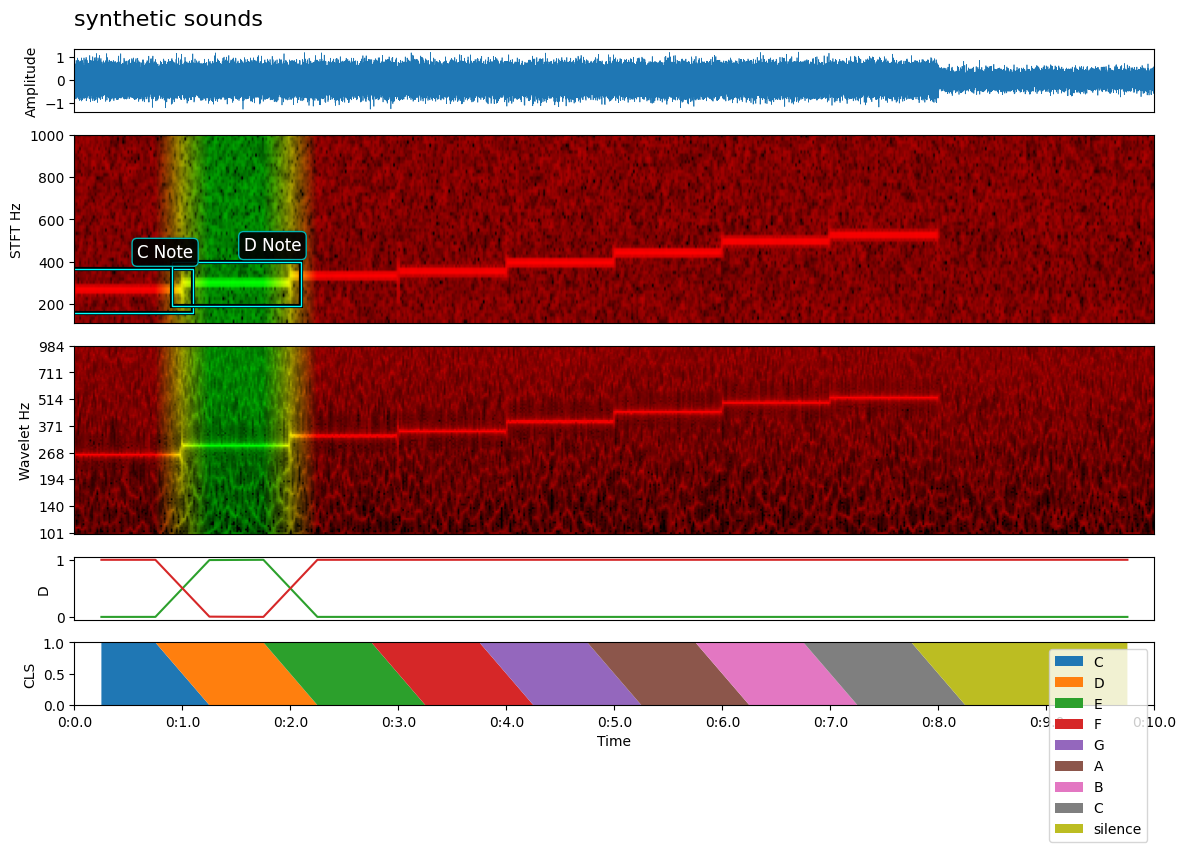

In [4]:
audio_file_processor = acv.AudioFileProcessor()

demo_labels = [
    acv.RavenLabel(bt=0, et=1, lf=frequencies[0]-100, hf=frequencies[0]+100, notes="C Note", score=0.95),
    acv.RavenLabel(bt=1, et=2, lf=frequencies[1]-100, hf=frequencies[1]+100, notes="D Note", score=0.85)
]

audio_file_visualizer = acv.AudioFileVisualizer(y=waveform,
                                                sr=sample_rate,
                                                resample_to_sr=8000,
                                                start_time=0, 
                                                end_time=15,
                                                feature_rate=features_per_second,
                                                class_probabilities=probabilities,
                                                n_fft=512,
                                                label_boxes=demo_labels,
                                                class_labels=labels,
                                                freq_range_of_interest=(100,1000)
                                                #freq_range_of_interest=(200,600)
                                                )

title = "synthetic sounds"
audio_file_visualizer.visualize_audio_file_fragment(title, width=12, height=8).show()

# TODO: read: https://github.com/OverLordGoldDragon/ssqueezepy/blob/master/ssqueezepy/README.md#performance-guide

## Zoom in to the transition

35.0


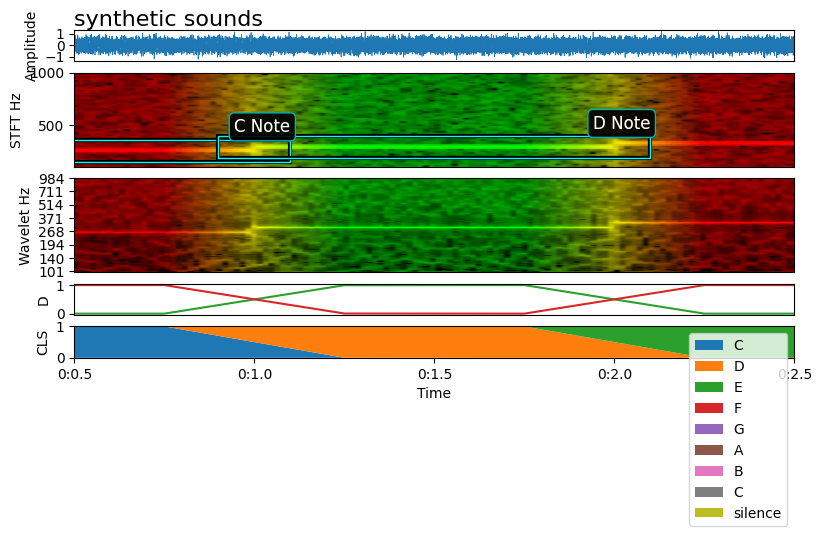

In [5]:
audio_file_visualizer.visualize_audio_file_fragment(title, 
                                                    start_time = 0.5, 
                                                    end_time=2.5,  
                                                    width=8, 
                                                    height=4).show()
